# Kernel Verification
-----
February 2017.

In [1]:
# preamble
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import clgen
from clgen import dbutil

import json

from labm8.py import fs
from labm8.py import viz

plt.style.use(["seaborn-white", "seaborn-paper"])

## 1. Experimental Results

Datasets:

In [2]:
!ls -lh ~/data/verify

total 107M
-rw-r--r-- 1 cec cec  58M Feb 26 02:04 cpu.db
-rw-rw-r-- 1 cec cec 1.8M Feb 26 02:04 cpu.log
-rw-r--r-- 1 cec cec  46M Feb 26 02:04 gpu.db
-rw-rw-r-- 1 cec cec 2.1M Feb 26 02:04 gpu.log


Load datasets. Set `in1` and `in2` appropriately:

In [3]:
in1 = fs.path("~/data/verify/cpu.db")
in2 = fs.path("~/data/verify/gpu.db")

in1base = fs.basename(in1)
in2base = fs.basename(in2)

db1 = dbutil.connect(in1)
db2 = dbutil.connect(in2)

c1 = db1.cursor()
c2 = db2.cursor()

c1.execute("ATTACH DATABASE '{in2}' AS rhs".format(**vars()))
c2.execute("ATTACH DATABASE '{in1}' AS rhs".format(**vars()))

n1 = dbutil.num_rows_in(in1, "Data")
n2 = dbutil.num_rows_in(in2, "Data")

c1.execute("""
SELECT COUNT(*)
FROM Data AS lData INNER JOIN rhs.Data AS rData ON lData.id=rData.id
""")
n3 = c1.fetchone()[0]

c1.execute("""
SELECT
    lData.id AS id,
    lData.status AS lstatus, rData.status AS rstatus,
    lData.result AS ldata, rData.result AS rdata
FROM Data AS lData INNER JOIN rhs.Data AS rData ON lData.id=rData.id
WHERE lData.result != "" AND rData.result != ""
""")
cdata = c1.fetchall()

print("Number of results for ", in1base, n1)
print("Number of results for ", in2base, n2)
print("Number of common results     ", n3)
print("Number of common good results", len(cdata))

Number of results for  cpu.db 13489
Number of results for  gpu.db 18070
Number of common results      5129
Number of common good results 940


## 2. Evaluation

### Per-device results

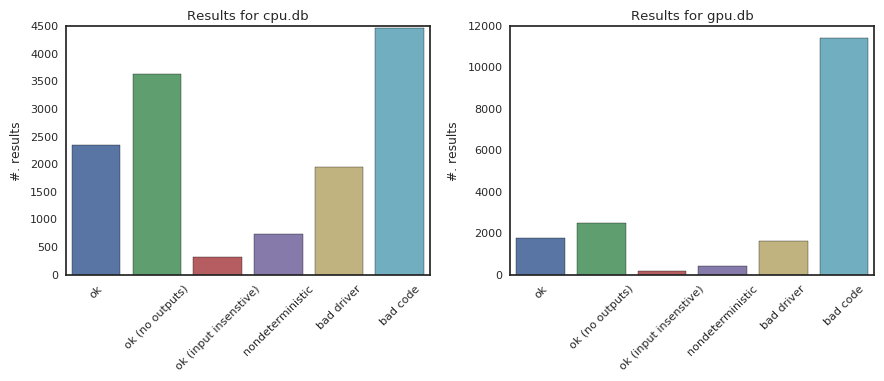

In [4]:
STATUS = ["ok", "ok (no outputs)", "ok (input insenstive)", "nondeterministic", "bad driver", "bad code"]

def plot_dist(path):
    basename = fs.basename(path)
    c = dbutil.connect(path).cursor()
    c.execute("SELECT status, COUNT(status) FROM Data GROUP BY status ORDER BY status")
    d = [{"status": STATUS[i], "n": x} for i, x in c.fetchall()]
    ax = sns.barplot(x="status", y="n", data=pd.DataFrame(d))
    plt.title("Results for {basename}".format(**vars()))
    plt.setp(ax.get_xticklabels(), rotation=45)  # rotate x ticks
    plt.xlabel("")
    plt.ylabel("#. results")

ax = plt.subplot(1, 2, 1)
plot_dist(in1)
ax = plt.subplot(1, 2, 2)
plot_dist(in2)

viz.finalise(figsize=(9, 4))

### Different results

In [5]:
from difflib import context_diff, unified_diff
import sys

numstatusdiff = 0
numdatadiff = 0

def get_src(c, id):
    c.execute("SELECT Source FROM Source WHERE id=?", (id,))
    r = c.fetchone()
    assert(len(r) == 1)
    return r[0]

for row in cdata:
    id, lstatus, rstatus, ldata, rdata = row
        
    if ldata != rdata:
        print("DATA mismatch", id)
        print(get_src(c1, id))
        numdatadiff += 1
        ld = json.loads(ldata)
        rd = json.loads(rdata)
        assert(len(ld) == len(rd))  # payloads should have same length
        for i, r in enumerate(zip(ld, rd)):
            a1, a2 = r
            if a1 != a2:
                assert(len(a1) == len(a2))
            
                t1 = ["{}\n".format(x) for x in a1]
                t2 = ["{}\n".format(x) for x in a2]
                diff = list(unified_diff(t1, t2,
                                         fromfile='before.py', tofile='after.py'))
                #print('\n'.join(t))
                print("DIFF OF ARG", i, "({} lines)".format(len(diff)))
                print(''.join(diff[:10]))
    elif lstatus != rstatus:
        print("STATUS mismatch", id, lstatus, rstatus)
        numstatusdiff += 1

ratiostatusdiff = numstatusdiff / len(cdata)
ratiodatadiff = numdatadiff / len(cdata)

print("Found {numstatusdiff} ({ratiostatusdiff:.2%}) cases with different statuses".format(**vars()))
print("Found {numdatadiff} ({ratiodatadiff:.2%}) cases with different data".format(**vars()))

DATA mismatch 2706a7641f6178a675e80452fbfeca7ff3102b61.cl
__kernel void A(__global int* a, __global int* b) {
  int c[32];
  int d[16];
  for (int e = 0; e < 16; ++e)
    d[e] = e;
  for (int e = 1; e < get_num_groups(0); ++e)
    a[e] += b[e];
}
DIFF OF ARG 0 (9 lines)
--- before.py
+++ after.py
@@ -1,5 +1,5 @@
 0
-3
+2
 2
 3
 4

STATUS mismatch dcae239e1575c36df29326d586a6f9d70e57fb43.cl 0 1
STATUS mismatch 9a16d4ce0fc164cb819a2a7c1508db9bd46629b5.cl 1 0
DATA mismatch e6b800e780afb35834c7d3ae96bbe57614e672fd.cl
__kernel void A(__global int* a, __global int* b, __global int* c) {
  int d = get_global_id(0);
  float e = b[d];

  a[d * (*c) + 0] = acos(e);
  a[d * (*c) + 2] = asin(e);
  a[d] = d;
}
DIFF OF ARG 0 (11 lines)
--- before.py
+++ after.py
@@ -1,6 +1,6 @@
--2147483648
+0
 1
--2147483648
+0
 3
 4

DATA mismatch 8438b222e9a30fee8e0ba7910f1cd16d0c6ff9e8.cl
__kernel void A(__global int* a) {
  a[0]++;
}
DIFF OF ARG 0 (8 lines)
--- before.py
+++ after.py
@@ -1,4 +1,4 @@
-2
+1
 1
 2